In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geocube

import xarray as xr
import time
from geocube.api.core import make_geocube

from netCDF4 import Dataset

directory = '/ocean/projects/ees210014p/xjliu/DATA/landuse/'

ERROR 1: PROJ: proj_create_from_database: Open of /ocean/projects/atm200007p/xjliu/miniconda3/envs/geocube_env/share/proj failed


# Note 
### 1.Tis_ComunIndigenas.shp are all points and small and therefore not included in the maps of IL lands. (They are not shown in the online ArGIS map)
### 2. BosqueProtector and ReservaFlorestal are not seen in the web map. 

## 1. plot the land use map

In [2]:
### natural protected area
N1=gpd.read_file(directory+'Raisg/ANPs/ANP_nacional.shp')
N1.head()

N2=gpd.read_file(directory+'Raisg/ANPs/ANP_nacional_puntual.shp') # not seen in the web map
N3=gpd.read_file(directory+'Raisg/ANPs/ANP_departamental.shp')
N4 = gpd.read_file(directory+'Raisg/ANPs/ANP_BosqueProtector.shp') # not seen the web map
N5=gpd.read_file(directory+'Raisg/ANPs/ReservaFlorestal.shp') # not seen in the web map

(-21.85, 10.72)

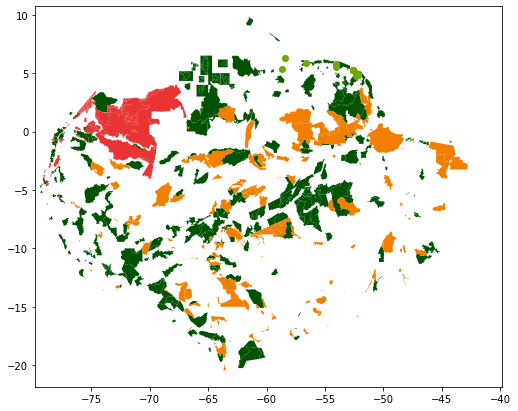

In [3]:
fig, ax = plt.subplots(1, 1,figsize=(12,7))
N1.plot(ax=ax,color=[0.0,0.326,0.0])
N2.plot(ax=ax,color=[0.437,0.663,.0])
N3.plot(ax=ax,color=[0.949,0.498,.0])
N4.plot(ax=ax,color=[0.918,0.201,0.200]) 
N5.plot(ax=ax,color=[0.918,0.201,0.200]) 

ax.set_xlim([-79.8,-39.85])
ax.set_ylim([-21.85,10.72])

(-21.85, 10.72)

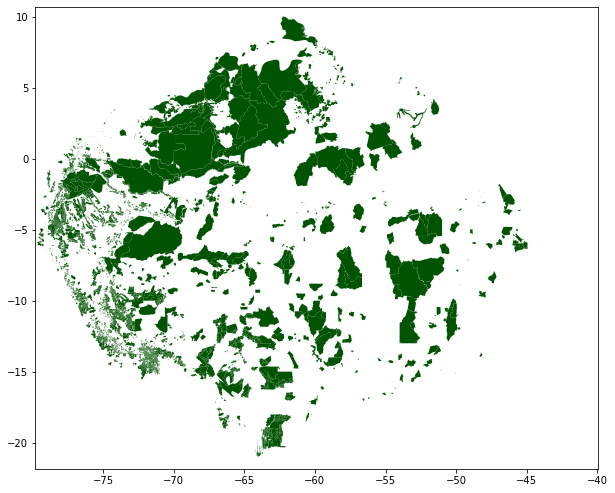

In [6]:
shapefile = 'Raisg/Tis_2020/Tis_TerritoriosIndigenas.shp'  
IL1 = gpd.read_file(directory+shapefile) # read into a GeoDataFrame
#IL2 = gpd.read_file(directory+'Raisg/Tis_2020/Tis_ComunIndigenas.shp') # what is this
fig, ax = plt.subplots(1, 1,figsize=(15,8.5))
IL1.plot(ax=ax,color=[0.0,0.326,0.0])
#IL2.plot(ax=ax,color=[0.437,0.663,.0],markersize=2)
ax.set_xlim([-79.8,-39.97])
ax.set_ylim([-21.85,10.72])

# IL = gpd.sjoin(IL1,IL2,how='left')  ## merge IL1 and IL2. 

(-21.85, 10.72)

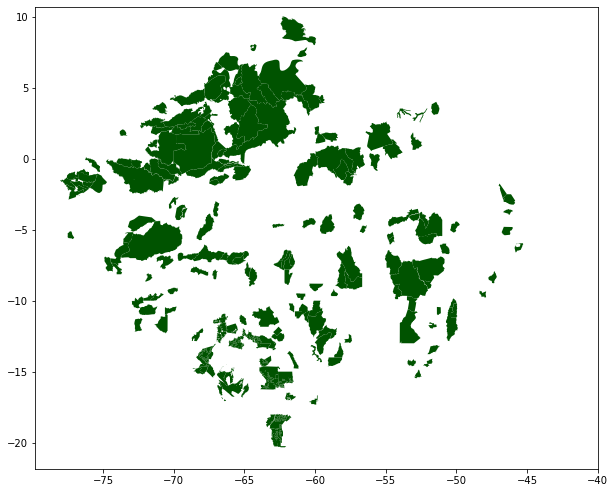

In [7]:
IL1.area_sig_h.max()
IL_big = IL1[IL1.area_sig_h>1.6e5]
fig, ax = plt.subplots(1, 1,figsize=(15,8.5))
IL_big.plot(ax=ax,color=[0.0,0.326,0.0])
#IL2.plot(ax=ax,color=[0.437,0.663,.0],markersize=2)
ax.set_xlim([-79.8,-39.97])
ax.set_ylim([-21.85,10.72])

### Rasterize the data

/ocean/projects/atm200007p/xjliu/miniconda3/envs/geocube_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


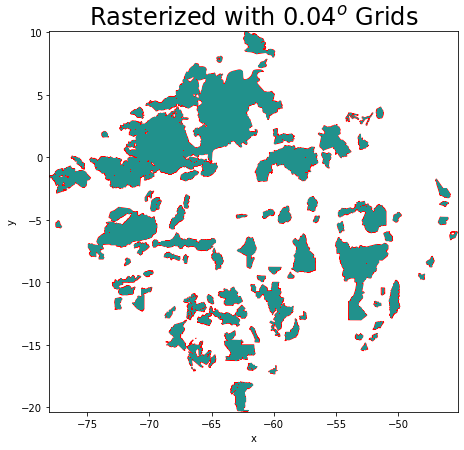

In [9]:
IL_big['value']=1
out_grid = make_geocube(IL_big,resolution=(0.04, -0.04),measurements=['value'],fill=-9999)
da_grib = xr.where(out_grid.value<-1999.0, np.nan, out_grid.value)

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1)
IL_big.plot(ax=ax, facecolor='None', edgecolor='r')
da_grib.plot(ax=ax, add_colorbar=False)
ax.set_title("Rasterized with 0.04$^o$ Grids", fontsize=24);

### Deforest IL

In [6]:
path='/jet/home/xjliu/Amazon_exp/'
with xr.open_dataset(path+'Amazon961x801_2005/wrfinput_d01_20050901',decode_times=False) as ds:
    print('ok')
lats = ds['XLAT'][0,:,:]
lons = ds['XLONG'][0,:,:]
luindex = ds['LU_INDEX'][:]

## change landuse index
from shutil import copyfile
import netCDF4

## change the da_grib of the corresponding domain of luindex
IL_sel = da_grib.sel(y=lats[:,0],x=lons[0,:],method='nearest')
IL_sel_3D = np.expand_dims(IL_sel,axis=0)

### change the file
fin = path+'Amazon961x801_2005/wrfinput_d01_20050901'
fout = path+'Amazon961x801_2005/wrfinput_d01_ILgrassland'
copyfile(fin, fout )
dset1 = netCDF4.Dataset(fout, 'r+')

luindex_new = xr.where(IL_sel_3D==1,10,luindex)  # replace forest with grassland
luindex_new = xr.where(luindex==17,luindex,luindex_new)  # change the LUindex back to water (17) where it is water

dset1['LU_INDEX'][:] = luindex_new
dset1.close() # if you want to write the variable back to disk

ok


### Check the newly generated luindex

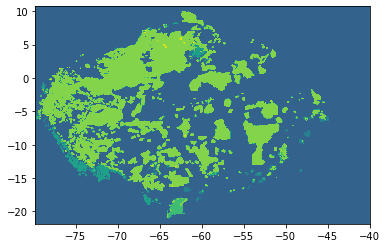

In [7]:
plt.contourf(lons,lats,luindex_new[0,:,:] - luindex[0,:,:])